In [1]:
from binance.client import Client
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross, resample_apply, plot_heatmaps
from skopt.plots import plot_objective
import scipy.optimize as spopt
from pykalman import KalmanFilter
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
"""

"""

'\n\n'

In [3]:
# DATA LOAD AND PROCESSING

In [4]:
# api_key = '123'
# api_secret = '123'

In [5]:
api_key = '123'
api_secret = '123'

In [6]:
client = Client(api_key, api_secret)

In [7]:
# List of pairs qouted in Tether
symbols = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT']

In [8]:
# Pairs' combination for Correlation and Coinegration analysis
pairs = list(combinations(symbols, 2))

In [9]:
#pairs

In [10]:
def generate_cross_pairs(symbols, base_symbol='BTC'):
    """
    Generate cross pairs qouted in the base symbol.
    """
    cross_pairs = [symbol.replace('USDT', 'BTC') for symbol in symbols[1:]]
    return cross_pairs

In [11]:
def split_pair(pair, quote_currency):
    return [pair[:3] + quote_currency, pair[3:] + quote_currency]

In [12]:
cross_pairs = generate_cross_pairs(symbols)

In [13]:
#cross_pairs

In [14]:
interval = Client.KLINE_INTERVAL_15MINUTE
start_date = '2023-01-01'
end_date = '2023-12-31'

In [15]:
def load_data(symbol, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbol
    """
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades',
               'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df = pd.DataFrame(klines, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df

In [16]:
def load_data_for_symbols(symbols, interval, start_date, end_date):
    """
    Load OHLCV MD for a symbols batch
    """
    data = {}
    for symbol in symbols:
        df = load_data(symbol, interval, start_date, end_date)
        data[symbol] = df
    return data

In [17]:
symbols_df = load_data_for_symbols(symbols, interval, start_date, end_date)

In [18]:
print(symbols_df.keys())

dict_keys(['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT'])


In [19]:
#print(symbols_df.items())

In [20]:
print(symbols_df['ETHUSDT'].head(1))

               Open     High      Low    Close     Volume
timestamp                                                
2023-01-01  1196.13  1196.69  1194.55  1194.55  1245.8855


In [21]:
# STATISTICAL ANALYSIS

In [22]:
def get_correl_matrix(data):
    """
    Get a Correlation matrix for a symbols batch
    """
    close_prices = pd.concat([df['Close'] for df in data.values()], axis=1)
    close_prices.columns = data.keys()
    return close_prices.corr()

In [23]:
def plot_correl_matrix(correl_matrix):
    """
    Plot a Correlation Heatmap
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(correl_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Close Prices')
    plt.xlabel('Symbols')
    plt.ylabel('Symbols')
    plt.show()

In [24]:
correl_matrix = get_correl_matrix(symbols_df)

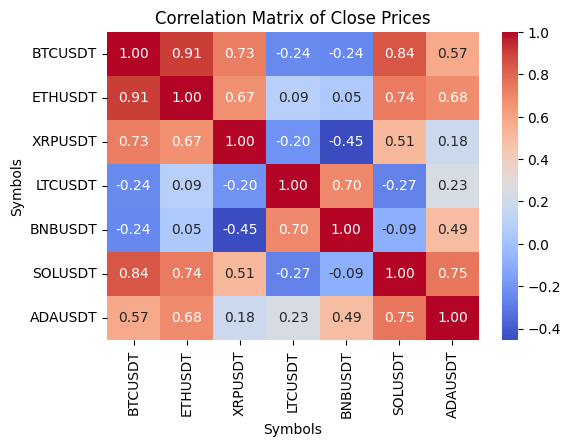

In [25]:
plot_correl_matrix(correl_matrix)

In [26]:
def cointegration_test(symbols_df, pairs):
    """
    Run a cointegration test result for all trading pairs
    """
    cointegration_results = {}
    for pair in pairs:
        # print(pair)
        symbol1_data = symbols_df[pair[0]]['Close'].astype(float)
        # print(symbol1_data.head())
        symbol2_data = symbols_df[pair[1]]['Close'].astype(float)
        # print(symbol1_data.head())
        result = sm.tsa.coint(symbol1_data, symbol2_data)
        # print(result)
        cointegration_results[pair] = result
    return cointegration_results

In [27]:
def plot_time_series(data, symbol_names):
    """
    Plot the time series of the given symbols
    """
    plt.figure(figsize=(10, 6))
    for symbol_name in symbol_names:
        plt.plot(data[symbol_name]['Close'].astype(float), label=symbol_name)
    plt.legend()
    plt.title('Time Series of Symbols')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

In [28]:
def plot_spread(symbol1_data, symbol2_data):
    """
    Plot the spread between two symbols
    """
    spread = symbol1_data - symbol2_data
    plt.figure(figsize=(10, 4))
    plt.plot(spread, label='Spread')
    plt.axhline(0, color='r', linestyle='--')  # Add zero line for reference
    plt.title('Spread between Symbols')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

In [29]:
def plot_cointegration_scatter(cointegration_results):
    """
    Plot cointegration test result curve

    """
    test_statistics = [result[0] for result in cointegration_results.values()]
    p_values = [result[1] for result in cointegration_results.values()]
    pair_names = list(cointegration_results.keys())

    plt.figure(figsize=(6, 8))
    plt.scatter(test_statistics, -np.log10(p_values), alpha=0.5)
    plt.xlabel('Test Statistic')
    plt.ylabel('-log10(P-value)')
    plt.title('Cointegration Test Results')

    # Annotate each point with pair name
    for i, pair_name in enumerate(pair_names):
        plt.annotate(pair_name, (test_statistics[i], -np.log10(p_values[i])), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8)

    plt.grid(True)
    plt.show()

In [30]:
def plot_cointegration_heatmap(coint_res, symbols):
    """
    Plot a heatmap of cointegration test result.
    """
    num_symbols = len(symbols)
    coint_matrix = np.zeros((num_symbols, num_symbols))

    for i, symbol1 in enumerate(symbols):
        for j, symbol2 in enumerate(symbols):
            if (symbol1, symbol2) in coint_res:
                coint_matrix[i, j] = -np.log10(coint_res[(symbol1, symbol2)][1])

    plt.figure(figsize=(4, 3))
    plt.imshow(coint_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='-log10(P-value)')
    plt.xticks(np.arange(num_symbols), symbols, rotation=45)
    plt.yticks(np.arange(num_symbols), symbols)
    plt.title('Cointegration Test Results')
    plt.xlabel('Symbol 1')
    plt.ylabel('Symbol 2')
    plt.show()

In [31]:
def print_cointegration_results(coint_res):
    """
    Print cointegration results
    """
    filtered_results = {pair: stats for pair, stats in coint_res.items() if 'BTC' in pair[0] or 'BTC' in pair[1]}
    sorted_results = sorted(filtered_results.items(), key=lambda x: x[1][1], reverse=False)
    for pair, (_, p_value, _) in sorted_results:
        symbol1, symbol2 = pair
        print(f"{symbol1} - {symbol2}: P-value = {p_value:.4f}")

In [32]:
coint_res = cointegration_test(symbols_df, pairs)

In [33]:
#coint_res

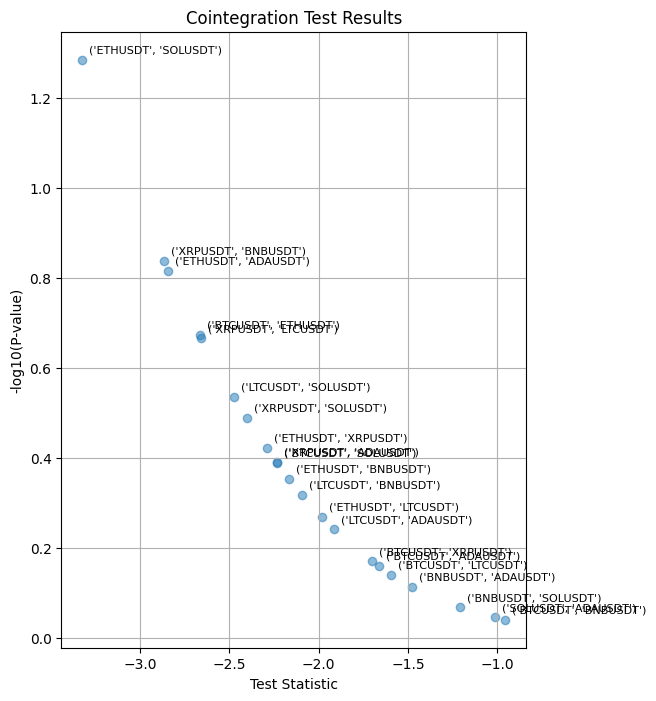

In [34]:
plot_cointegration_scatter(coint_res)

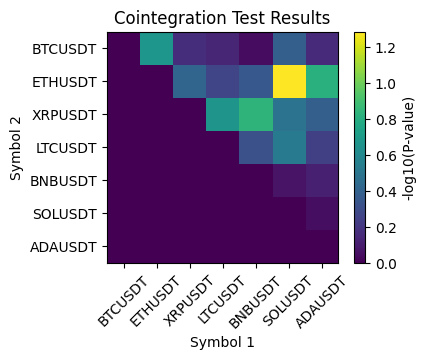

In [35]:
plot_cointegration_heatmap(coint_res, symbols)

In [36]:
print_cointegration_results(coint_res)

BTCUSDT - ETHUSDT: P-value = 0.2124
BTCUSDT - SOLUSDT: P-value = 0.4083
BTCUSDT - XRPUSDT: P-value = 0.6759
BTCUSDT - ADAUSDT: P-value = 0.6930
BTCUSDT - LTCUSDT: P-value = 0.7237
BTCUSDT - BNBUSDT: P-value = 0.9108
